In [17]:
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import statsmodels.api as sm
import scipy.stats as st
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import train_test_split
from datetime import date, datetime

%matplotlib inline

In [18]:
df_out = pd.read_pickle('df_out.pkl')
df_out_with_breeds_info = pd.read_pickle('df_out_with_breeks_info.pkl')
df_out.info()
df_out_with_breeds_info.info()
df_out.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 149511 entries, 0 to 149510
Data columns (total 41 columns):
 #   Column                    Non-Null Count   Dtype         
---  ------                    --------------   -----         
 0   index                     149511 non-null  Int64         
 1   Animal ID                 149511 non-null  string        
 2   Name                      106260 non-null  string        
 3   Outcome DateTime          149511 non-null  datetime64[ns]
 4   Outcome MonthYear         149511 non-null  string        
 5   Date of Birth             149511 non-null  datetime64[ns]
 6   Outcome Type              149485 non-null  string        
 7   Outcome Subtype           68443 non-null   string        
 8   Animal Type               149511 non-null  string        
 9   Sex upon Outcome          149509 non-null  string        
 10  Age upon Outcome          149465 non-null  string        
 11  Breed                     149511 non-null  string        
 12  Co

,index,Animal ID,Name,Outcome DateTime,Outcome MonthYear,Date of Birth,Outcome Type,Outcome Subtype,Animal Type,Sex upon Outcome,...,Color 1 G,Color 1 B,Color 1 H,Color 1 S,Color 1 V,Age upon Outcome (years),Male,Female,NeuteredOrSpayed,Adopted
0,61546,A659834,Dudley,2013-10-01 09:31:00,Oct 2013,2013-07-23,Adoption,Foster,Dog,Neutered Male,...,<NA>,<NA>,<NA>,<NA>,<NA>,0.166667,True,False,True,True
1,50833,A664235,<NA>,2013-10-01 10:39:00,Oct 2013,2013-09-24,Transfer,Partner,Cat,Unknown,...,1.0,1.0,0.0,0.0,1.0,0.019231,False,False,False,False
2,93227,A664236,<NA>,2013-10-01 10:44:00,Oct 2013,2013-09-24,Transfer,Partner,Cat,Unknown,...,1.0,1.0,0.0,0.0,1.0,0.019231,False,False,False,False
3,109856,A664237,<NA>,2013-10-01 10:44:00,Oct 2013,2013-09-24,Transfer,Partner,Cat,Unknown,...,1.0,1.0,0.0,0.0,1.0,0.019231,False,False,False,False
4,12697,A664223,Moby,2013-10-01 11:03:00,Oct 2013,2009-09-30,Return to Owner,<NA>,Dog,Neutered Male,...,<NA>,<NA>,<NA>,<NA>,<NA>,4.0,True,False,True,False


In [19]:
def population(start, end):
    loc_intake = (df_out['Intake DateTime'].isna() | (df_out['Intake DateTime'] < end))
    loc_outcome = (df_out['Outcome DateTime'].isna() | (df_out['Outcome DateTime'] >= start))
    return df_out.loc[loc_intake & loc_outcome]

In [20]:
start = datetime(2014, 1, 1)
end = datetime(2023, 4, 1)
offset = datetime(start.year, start.month, start.day)

window_start = 'Window start'
window_end = 'Window end'
feature_1 = 'Intakes'
feature_1x_classes = df_out['Intake Type'].unique()
feature_1y_classes = df_out['Intake Condition'].unique()
feature_1x = [f'Intakes Types ({feature_class})' for feature_class in feature_1x_classes]
feature_1y = [f'Intakes Conditions ({feature_class})' for feature_class in feature_1y_classes]
feature_2 = 'Outcomes'
feature_2x_classes = df_out['Outcome Type'].unique()
feature_2x = [f'Outcomes ({feature_class})' for feature_class in feature_2x_classes]
feature_3 = 'Breeds (unique)'
feature_4 = 'Animals (count)'
feature_5a = 'Years in animal center (mean)'
feature_5b = 'Years in animal center (std dev)'

df_populations = pd.DataFrame()

df_populations[window_start] = pd.Series(dtype=df_out["Outcome DateTime"].dtype)
df_populations[window_end] = pd.Series(dtype=df_out["Outcome DateTime"].dtype)

df_populations.set_index(window_start)

df_populations[feature_1] = pd.Series(dtype=int)
for feature in feature_1x:
    df_populations[f'{feature} (Absolute)'] = pd.Series(dtype=int)
    df_populations[f'{feature} (Relative)'] = pd.Series(dtype=float)
df_populations = df_populations.copy()
for feature in feature_1y:
    df_populations[feature] = pd.Series(dtype=int)
    df_populations[f'{feature} (Absolute)'] = pd.Series(dtype=int)
    df_populations[f'{feature} (Relative)'] = pd.Series(dtype=float)
df_populations = df_populations.copy()

df_populations[feature_2] = pd.Series(dtype=int)
for feature in feature_2x:
    df_populations[feature] = pd.Series(dtype=int)
    df_populations[f'{feature} (Absolute)'] = pd.Series(dtype=int)
    df_populations[f'{feature} (Relative)'] = pd.Series(dtype=float)
df_populations = df_populations.copy()

df_populations[feature_3] = pd.Series(dtype=int)

df_populations = df_populations.copy()

while offset != end:
    offset_next = datetime(offset.year + (1 if offset.month == 12 else 0), (offset.month % 12) + 1, offset.day)
    
    df_populations.at[offset, window_start] = offset
    df_populations.at[offset, window_end] = offset_next
    
    animals = population(offset, offset_next)
    
    intakes = animals.loc[(animals['Intake DateTime'] >= offset) & (animals['Intake DateTime'] < offset_next)]
    df_populations.at[offset, feature_1] = intakes.shape[0]
    for feature_class, count in intakes['Intake Type'].value_counts().items():
        df_populations.at[offset, f'Intakes Types ({feature_class}) (Absolute)'] = count
        df_populations.at[offset, f'Intakes Types ({feature_class}) (Relative)'] = count / intakes.shape[0]
    for feature_class, count in intakes['Intake Condition'].value_counts().items():
        df_populations.at[offset, f'Intakes Conditions ({feature_class}) (Absolute)'] = count
        df_populations.at[offset, f'Intakes Conditions ({feature_class}) (Relative)'] = count / intakes.shape[0]
    
    outcomes = animals.loc[(animals['Outcome DateTime'] >= offset) & (animals['Outcome DateTime'] < offset_next)]
    df_populations.at[offset, feature_2] = outcomes.shape[0]
    for feature_class, count in outcomes['Outcome Type'].value_counts().items():
        df_populations.at[offset, f'Outcome Types ({feature_class}) (Absolute)'] = count
        df_populations.at[offset, f'Outcome Types ({feature_class}) (Relative)'] = count / outcomes.shape[0]
    
    df_populations.at[offset, feature_3] = len(animals['Breed'].unique())
    df_populations.at[offset, feature_4] = animals.shape[0]
    
    df_populations.at[offset, feature_5a] = animals["Years in animal center"].mean()
    df_populations.at[offset, feature_5b] = animals["Years in animal center"].std()
    
    offset = offset_next

In [21]:
df_populations['Month'] = pd.Series(dtype=int)
df_populations['Year'] = pd.Series(dtype=int)
for index in df_populations.index:
    df_populations.at[index, 'Month'] = df_populations.at[index, window_start].month
    df_populations.at[index, 'Year'] = df_populations.at[index, window_start].year

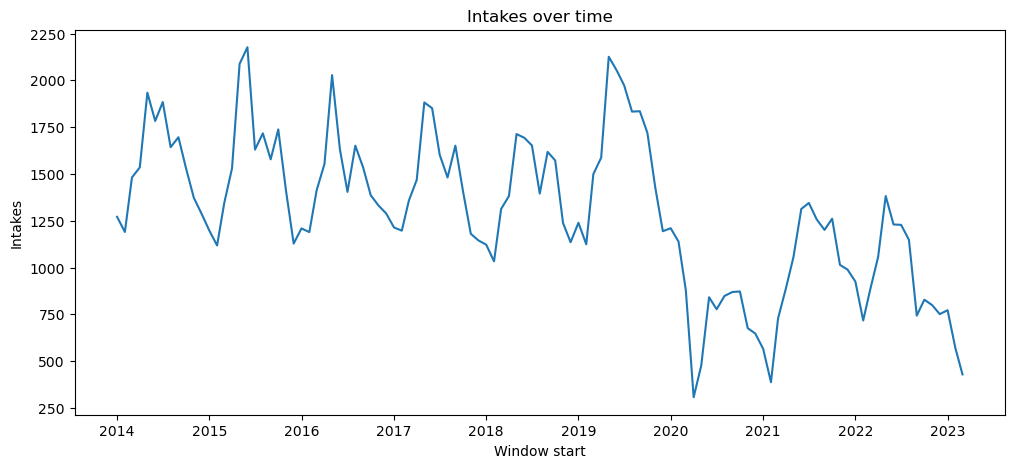

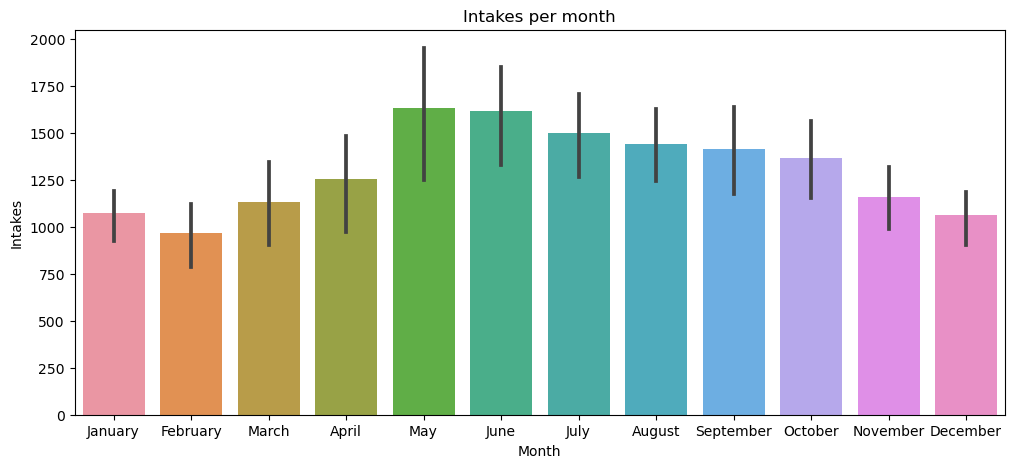

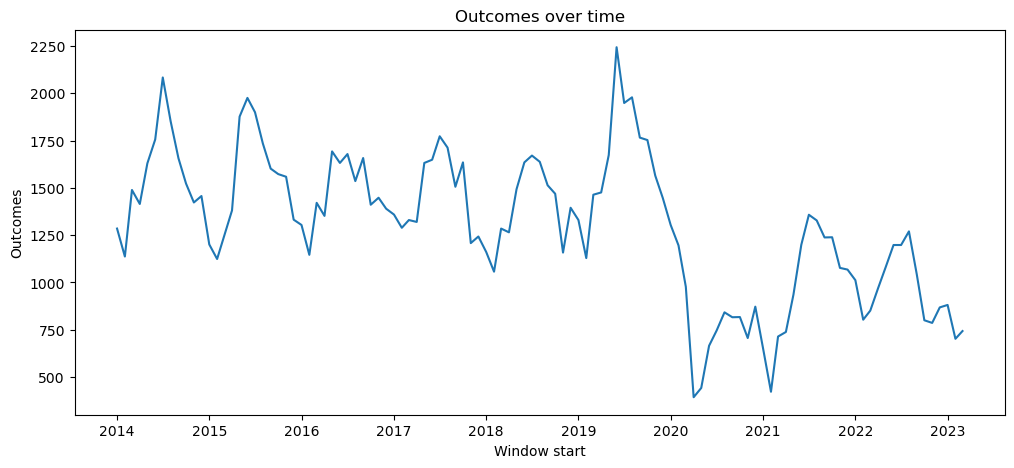

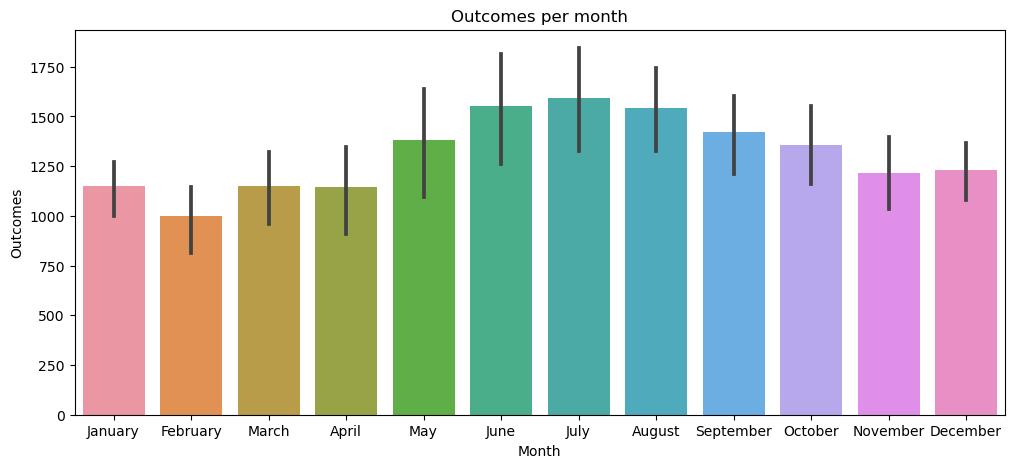

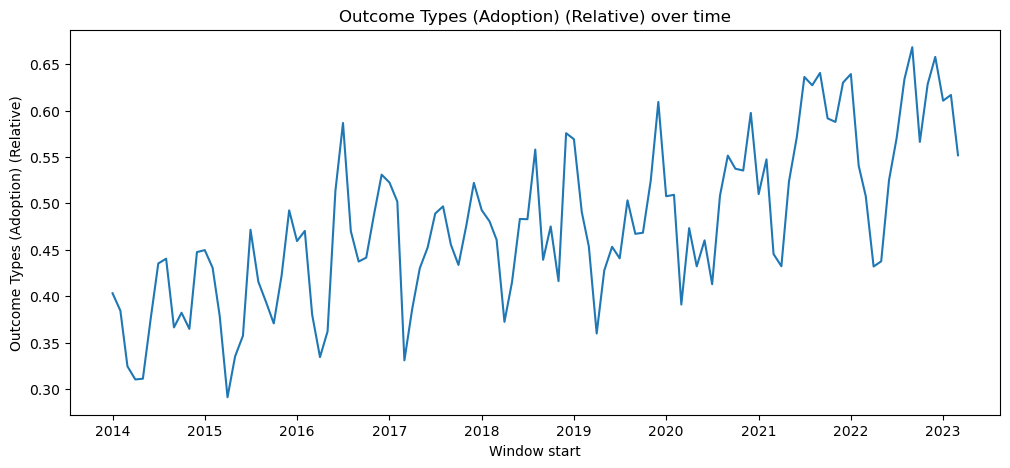

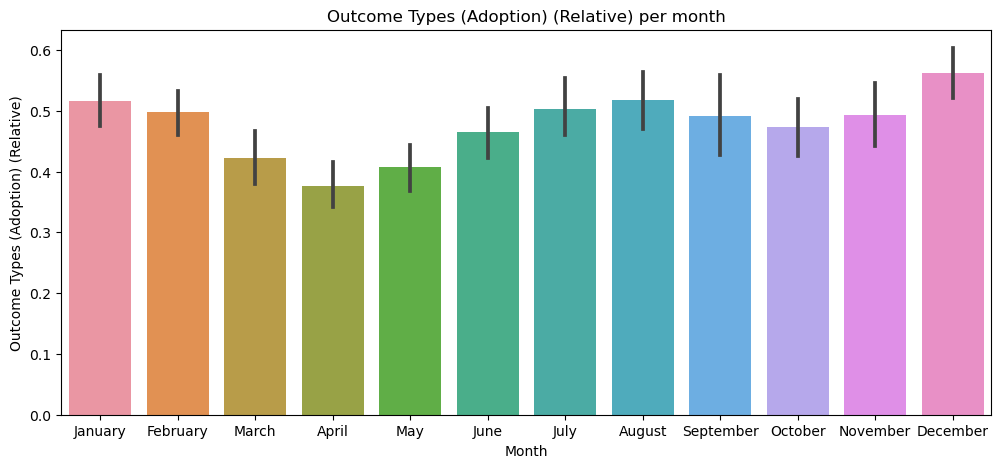

In [22]:
def populationCharts(feature):
    plt.figure(figsize=(12, 5))
    sns.lineplot(
        data=df_populations,
        x=window_start,
        y=feature
    )
    plt.title(f'{feature} over time')
    plt.show()

    plt.figure(figsize=(12, 5))
    sns.barplot(
        data=df_populations,
        x='Month',
        y=feature,
    )
    plt.xticks(range(12), ["January", "February", "March", "April", "May", "June", "July", "August", "September", "October", "November", "December"])
    plt.title(f'{feature} per month')
    plt.show()
    
populationCharts('Intakes')
populationCharts('Outcomes')
populationCharts('Outcome Types (Adoption) (Relative)')

In [23]:
df_populations.Year.head(20)

2014-01-01    2014.0
2014-02-01    2014.0
2014-03-01    2014.0
2014-04-01    2014.0
2014-05-01    2014.0
2014-06-01    2014.0
2014-07-01    2014.0
2014-08-01    2014.0
2014-09-01    2014.0
2014-10-01    2014.0
2014-11-01    2014.0
2014-12-01    2014.0
2015-01-01    2015.0
2015-02-01    2015.0
2015-03-01    2015.0
2015-04-01    2015.0
2015-05-01    2015.0
2015-06-01    2015.0
2015-07-01    2015.0
2015-08-01    2015.0
Name: Year, dtype: float64

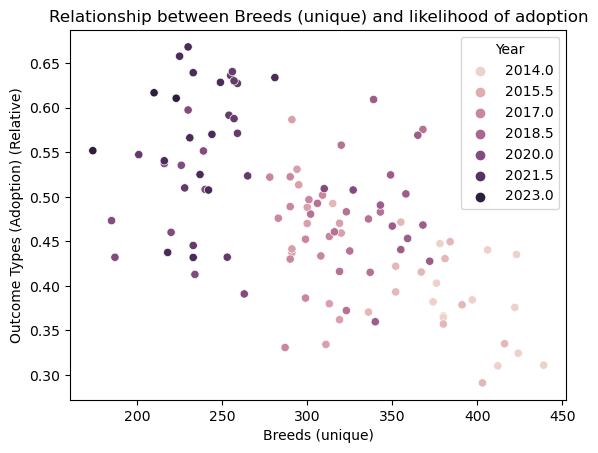

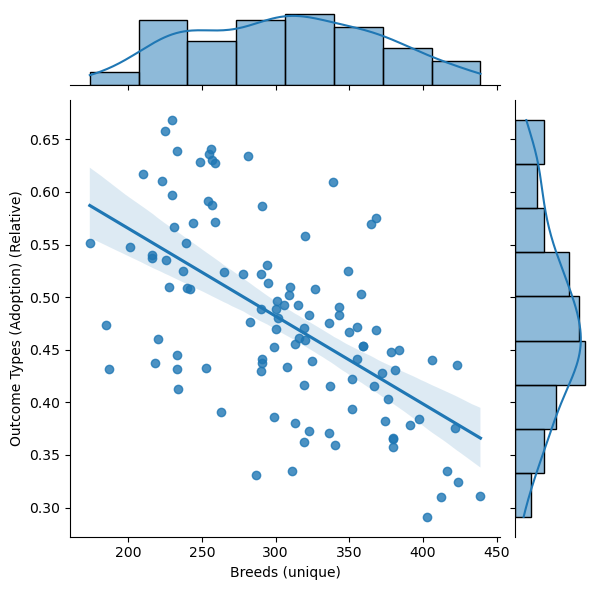

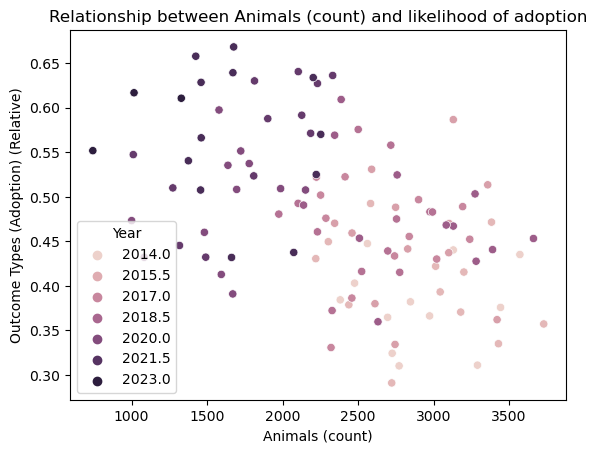

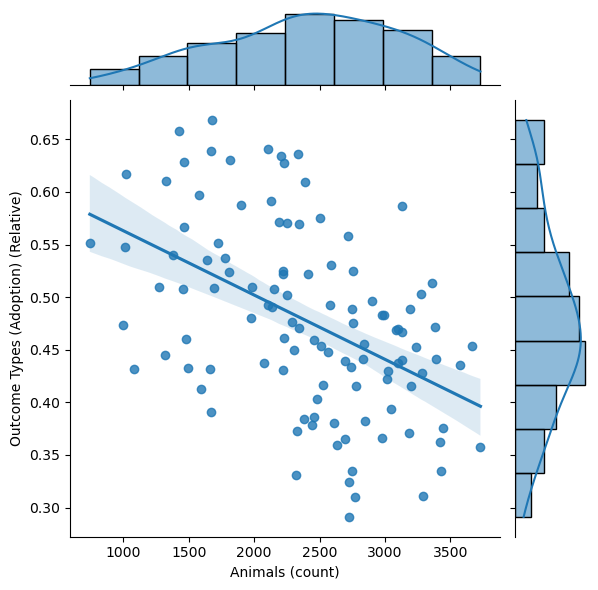

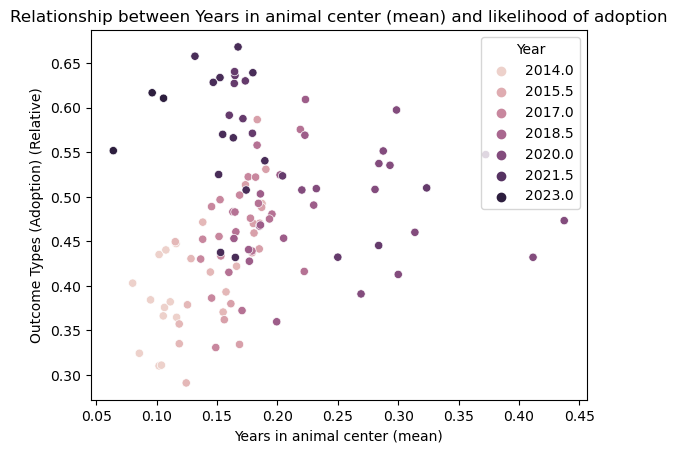

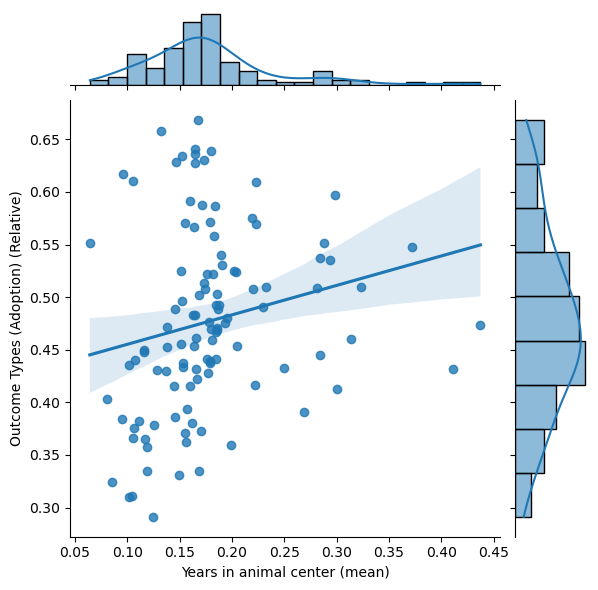

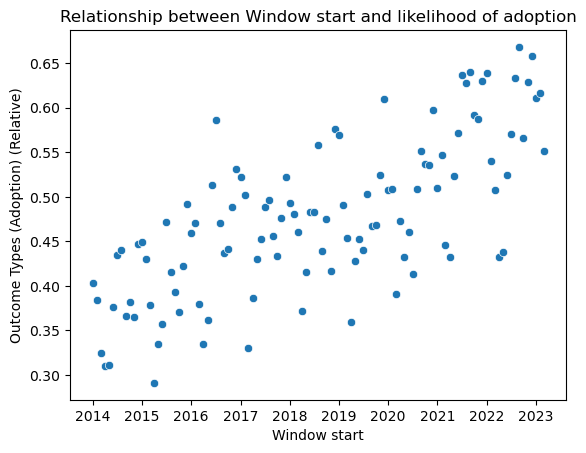

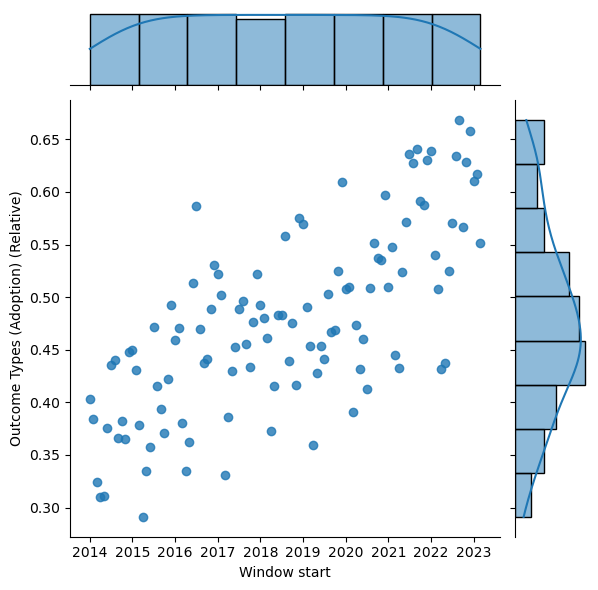

In [25]:
def adoptionCorr(feature, hue):
    sns.scatterplot(
        data=df_populations,
        x=feature,
        y='Outcome Types (Adoption) (Relative)',
        hue=hue
    )
    plt.title(f"Relationship between {feature} and likelihood of adoption")
    plt.show()

    try:
        sns.jointplot(
            data=df_populations,
            x=feature,
            y='Outcome Types (Adoption) (Relative)',
            kind='reg'
        )
        plt.show()
    except: pass
    
adoptionCorr(feature_3, 'Year')
adoptionCorr(feature_4, 'Year')
adoptionCorr(feature_5a, 'Year')
adoptionCorr(window_start, None)